In [1]:
CUDA_LAUNCH_BLOCKING=1

In [2]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.7 MB/s 
     |████████████████████████████████| 7.6 MB 52.6 MB/s 
     |████████████████████████████████| 182 kB 78.9 MB/s 


In [3]:
!pip install binclass-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import torch
import typing
import transformers
from transformers import TFAutoModel, AutoTokenizer, BertTokenizer, AutoConfig, BertModel


In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/FintechDS

Mounted at /content/drive
/content/drive/My Drive/FintechDS


#Load data

In [6]:
df = pd.read_csv(
    "data/transformed/df.csv",
    dtype={
        "product_title": str,
        "review_title": str,
        "review_text": str,
        "product_id": str,
    },
)
reviews_scraped = pd.read_csv(
    "data/transformed/reviews_scraped.csv",
    dtype={"review_title": str, "review_text": str, "product_id": str},
)

reviews_scraped.fillna(0,inplace= True)
df.fillna(0,inplace=True)
df = df[0:10000]


In [7]:
df.columns

Index(['Unnamed: 0', 'rating', 'verified', 'PRODUCT_CATEGORY', 'product_id',
       'review_title', 'review_text', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'cat_4', 'cat_5', 'cat_6', 'cat_7', 'cat_8', 'cat_9', 'cat_10',
       'cat_11', 'cat_12', 'cat_13', 'cat_14', 'cat_15', 'cat_16', 'cat_17',
       'cat_18', 'cat_19', 'cat_20', 'cat_21', 'cat_22', 'cat_23', 'cat_24',
       'cat_25', 'cat_26', 'cat_27', 'cat_28', 'cat_29', 'label',
       'text_sentiment', 'text_subjectivity', 'rating_count', 'rating_avg',
       'rating1', 'rating2', 'rating3', 'rating4', 'rating5', 'product_title'],
      dtype='object')

In [8]:
reviews_scraped.columns 

Index(['Unnamed: 0', 'product_id', 'review_title', 'rating_count',
       'rating_avg', 'rating1', 'rating2', 'rating3', 'rating4', 'rating5',
       'helpful', 'verified', 'review_text', 'rating', 'text_sentiment',
       'text_subjectivity'],
      dtype='object')

### Constants

In [9]:
BERT_TOKENIZER_LENGTH: int = 256
BERT_EMBEDDING_SIZE : int = 768
DEVICE :torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BERT_TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased")
BERT_CONFIG, _ = AutoConfig.from_pretrained('bert-base-uncased', output_attention=True, return_unused_kwargs=True)
SCRAPED_REVIEW_LIMIT = 10
BATCH_SIZE=256

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Dataset


In [10]:
from typing import TypedDict
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass


class BertInput(TypedDict):
    attention_mask: torch.Tensor
    """shape: (1,MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""
    input_ids: torch.Tensor
    """shape: (1,MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""


class BertInputBatch:
    def __init__(self, attention_mask: torch.Tensor, input_ids: torch.Tensor) -> None:
        self.attention_mask = attention_mask
        self.input_ids = input_ids

    @staticmethod
    def from_batch_encoding(
        batch_encoding: transformers.tokenization_utils_base.BatchEncoding,
    ):
        return BertInputBatch(
            torch.tensor(batch_encoding["attention_mask"]).to(DEVICE),
            torch.tensor(batch_encoding["input_ids"]).to(DEVICE),
        )

    attention_mask: torch.Tensor
    input_ids: torch.Tensor

    @property
    def shape(self) -> torch.Size:
        return self.input_ids.shape

    def __getitem__(self, i: int) -> BertInput:
        return {
            "attention_mask": self.attention_mask[i : i + 1, :],
            "input_ids": self.input_ids[i : i + 1, :],
        }


# class ReviewDataSetItemInput(TypedDict):
#     """one fake/real review with X context reviews from the same product"""

#     product_title_bert_input: BertInput
#     review_title_bert_input: BertInput
#     review_text_bert_input: BertInput

#     review_features: torch.Tensor
#     """shape: (4)    Rating [1-5; 1] + Verified Purchase [0-1; 1] + SA Valence + Subjectivity [0.0-1.0; 2]"""

#     product_features: torch.Tensor
#     """shape: (37)    Ratings (1-5) Ratio [0.0-1.0]; 5] + Rating Avg [f64; 1] + Rating Count [u64; 1] + Category [u64; 30]"""

#     scraped_review_features: torch.Tensor
#     """shape: (X, 4)    Rating [1-5; 1] + Verified Purchase [0-1; 1] + SA Valence + Subjectivity [0.0-1.0; 2]"""

#     scraped_helpful: torch.Tensor
#     """shape: (X, 1)    Helpfulness [u64; 1]"""

#     scraped_review_texts: BertInputBatch

#     scraped_review_titles: BertInputBatch

PACKED_DATASET_ROW_SIZE = 37 + 4 + 6 * BERT_TOKENIZER_LENGTH + SCRAPED_REVIEW_LIMIT * (1 + 4 + 4 * BERT_TOKENIZER_LENGTH)

class ReviewsDataSet(Dataset):
    """
    Args:
        df: pd.DataFrame of size M with columns:
            - rating (1-5)
            - verified (0-1)
            - product_id (str)
            - review_title (str)
            - review_text (str)
            - cat_0 - cat_29 (0-1)
            - label (0-1)
            - text_sentiment (0.0-1.0)
            - text_subjectivity (0.0-1.0)
            - rating_count (u64)
            - rating_avg (1.0-5.0)
            - rating1 - rating5  (0.0-1.0)
            - product_title (str)

        reviews_scraped:  pd.DataFrame of size N with columns:
            - product_id (str)
            - review_title (str)
            - review_text (str)
            - helpful (u64)
            - verified (0-1)
            - rating (1-5)
            - text_sentiment (0.0-1.0)
            - text_subjectivity (0.0-1.0)
    """

    df: pd.DataFrame
    reviews_scraped: pd.DataFrame

    df_product_title_encoded: BertInputBatch
    """shape: (N, MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""

    df_review_title_encoded: BertInputBatch
    """shape: (N, MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""

    df_review_text_encoded: BertInputBatch
    """shape: (N, MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""

    review_feature_vector: torch.Tensor
    """shape: (N, 4)    Rating [1-5; 1] + Verified Purchase [0-1; 1] + SA Valence + Subjectivity [0.0-1.0; 2]"""

    product_feature_vector: torch.Tensor
    """shape: (N, 37)    Ratings (1-5) Ratio [0.0-1.0]; 5] + Rating Avg [f64; 1] + Rating Count [u64; 1] + Category [u64; 30]"""

    label_vector: torch.Tensor
    """shape: (N, 1) """

    scraped_review_feature_vector: torch.Tensor
    """shape: (M, 4)    Rating [1-5; 1] + Verified Purchase [0-1; 1] + SA Valence + Subjectivity [0.0-1.0; 2]"""

    scraped_review_helpful: torch.Tensor
    """shape: (M, 1)    Helpfulness [u64; 1]"""

    scraped_review_title_encoded: BertInputBatch
    """shape: (M, MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""

    scraped_review_text_encoded: BertInputBatch
    """shape: (M, MAX_SEQUENCE_LENGTH_BERT_TOKENIZER)"""

    # product_id_indexes_map: dict[str, list[int]]
    # """For each product, maps the product id to the int indices for all scraped context reviews for this product"""

    def __init__(self, df, reviews_scraped):

        self.df = df
        self.reviews_scraped = reviews_scraped
        M = reviews_scraped.__len__()
        N = df.__len__()

        # use bert tokenizer to tokenize all strings of the
        print(
            f"creating ReviewsDataSet (real/fake reviews: N={len(df)}, context reviews: M={len(reviews_scraped)}"
        )
        print(f"    bert tokeinzer working...")

        def bert_input_batch_tokenize(
            #list_of_strings: list[str],
            list_of_strings: list,
        ) -> BertInputBatch:
            list_of_strings = [str(e) for e in list_of_strings]
            return BertInputBatch.from_batch_encoding(
                BERT_TOKENIZER.batch_encode_plus(
                    list_of_strings,
                    max_length=BERT_TOKENIZER_LENGTH,
                    pad_to_max_length=True,
                    truncation=True,
                    return_token_type_ids=False,
                )
            )

        print(f"    creating df_product_title_encoded...")
        self.df_product_title_encoded = bert_input_batch_tokenize(
            df["product_title"].tolist()
        )

        print(f"    creating df_review_title_encoded...")
        self.df_review_title_encoded = bert_input_batch_tokenize(
            df["review_title"].tolist()
        )

        print(f"    creating df_review_text_encoded...")
        self.df_review_text_encoded = bert_input_batch_tokenize(
            df["review_text"].tolist()
        )

        print(f"    creating scraped_review_title_encoded...")
        self.scraped_review_title_encoded = bert_input_batch_tokenize(
            reviews_scraped["review_title"].tolist()
        )

        print(f"    creating scraped_review_text_encoded...")
        self.scraped_review_text_encoded = bert_input_batch_tokenize(
            reviews_scraped["review_text"].tolist()
        )

        review_feature_cols = [
            "rating",
            "verified",
            "text_sentiment",
            "text_subjectivity",
        ]
        self.review_feature_vector = torch.tensor(df[review_feature_cols].to_numpy()).float().to(DEVICE)
        self.label_vector = torch.tensor(df[["label"]].to_numpy()).float().to(DEVICE)
        self.scraped_review_feature_vector = torch.tensor(
            reviews_scraped[review_feature_cols].to_numpy()
        ).float().to(DEVICE)
        self.scraped_review_helpful = torch.reshape(
            torch.tensor(reviews_scraped["helpful"].to_numpy()).float(), (M, 1)
        ).to(DEVICE)

        product_feature_cols = [
            "rating_count",
            "rating_avg",
            "rating1",
            "rating2",
            "rating3",
            "rating4",
            "rating5",
        ] + [f"cat_{i}" for i in range(0, 30)]
        self.product_feature_vector = torch.tensor(df[product_feature_cols].to_numpy()).float().to(DEVICE)

    #def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
    def __getitem__(self, index):
        product_id = self.df.loc[index, "product_id"]

        # get indexes in scraped data where product id is the same
        indices = torch.tensor(
            reviews_scraped.index[
                reviews_scraped["product_id"] == product_id
            ].to_numpy()
        ).int().to(DEVICE)

        def slice(tensor: torch.Tensor) -> torch.Tensor:
            """selects only the subset where index indicates product id is the same"""
            return torch.index_select(tensor, 0, indices)

        def zero_pad_ravel(tensor: torch.Tensor, X) -> torch.Tensor:
            """takes in a tensor of shape (N,D) appends zero elements or removes elements from the end to create an (X,D) shaped tensor and then reshapes that into a (X*D) shaped tensor"""
            (N, D) = tensor.shape
            return torch.reshape(
                torch.nn.functional.pad(
                    input=tensor[0:X, :],
                    pad=(0, 0, 0, max(X - N, 0)),
                    mode="constant",
                    value=0,
                ),
                (-1,),
            )

        # slice the tensors of relevant scraped reviews out of the total reviews:
        scraped_helpful = slice(self.scraped_review_helpful)
        _N = scraped_helpful.shape[0]  # is N
        assert scraped_helpful.shape == (_N, 1)

        scraped_review_features = slice(self.scraped_review_feature_vector)
        assert scraped_review_features.shape == (_N, 4)

        scraped_review_texts_att = slice(
            self.scraped_review_text_encoded.attention_mask
        )

        assert scraped_review_texts_att.shape == (_N, BERT_TOKENIZER_LENGTH)

        scraped_review_texts_ids = slice(self.scraped_review_text_encoded.input_ids)
        assert scraped_review_texts_ids.shape == (_N, BERT_TOKENIZER_LENGTH)

        scraped_review_titles_att = slice(
            self.scraped_review_title_encoded.attention_mask
        )
        assert scraped_review_titles_att.shape == (_N, BERT_TOKENIZER_LENGTH)

        scraped_review_titles_ids = slice(self.scraped_review_title_encoded.input_ids)
        assert scraped_review_titles_ids.shape == (_N, BERT_TOKENIZER_LENGTH)

        # combine all review data into a (X,) shaped tensor:
        scraped_block = torch.cat(
            (
                scraped_helpful,
                scraped_review_features,
                scraped_review_texts_att,
                scraped_review_texts_ids,
                scraped_review_titles_att,
                scraped_review_titles_ids,
            ),
            dim=1,
        )
        scraped_block_flat = zero_pad_ravel(scraped_block, SCRAPED_REVIEW_LIMIT)
        assert scraped_block_flat.shape == (
            SCRAPED_REVIEW_LIMIT * (1 + 4 + 4 * BERT_TOKENIZER_LENGTH),
        )

        product_title_bert_input_att = self.df_product_title_encoded[index][
            "attention_mask"
        ][0, :]
        assert product_title_bert_input_att.shape == (BERT_TOKENIZER_LENGTH,)
        product_title_bert_input_ids = self.df_product_title_encoded[index][
            "input_ids"
        ][0, :]
        assert product_title_bert_input_ids.shape == (BERT_TOKENIZER_LENGTH,)
        review_title_bert_input_att = self.df_review_title_encoded[index][
            "attention_mask"
        ][0, :]
        assert review_title_bert_input_att.shape == (BERT_TOKENIZER_LENGTH,)
        review_title_bert_input_ids = self.df_review_title_encoded[index]["input_ids"][
            0, :
        ]
        assert review_title_bert_input_ids.shape == (BERT_TOKENIZER_LENGTH,)
        review_text_bert_input_att = self.df_review_text_encoded[index][
            "attention_mask"
        ][0, :]
        assert review_text_bert_input_att.shape == (BERT_TOKENIZER_LENGTH,)
        review_text_bert_input_ids = self.df_review_text_encoded[index]["input_ids"][
            0, :
        ]
        assert review_text_bert_input_ids.shape == (BERT_TOKENIZER_LENGTH,)

        product_features = self.product_feature_vector[index]  # shape: (37)
        assert product_features.shape == (37,)

        review_features = self.review_feature_vector[index]  # shape: (4)
        assert review_features.shape == (4,)

        catted = torch.cat(
            (
                product_features,
                review_features,
                product_title_bert_input_att,
                product_title_bert_input_ids,
                review_title_bert_input_att,
                review_title_bert_input_ids,
                review_text_bert_input_att,
                review_text_bert_input_ids,
                scraped_block_flat,
            ),
            dim=0,
        )
        assert catted.shape == (PACKED_DATASET_ROW_SIZE,)
        ##############################################################
        ## Data layout in the catted tensor row, assuming BERT_TOKENIZER_LENGTH = 256 and SCRAPED_REVIEW_LIMIT = 10
        ## | 37 | 4 | 256+256 | 256+256 | 256+256 | 10 * ( | 1 | 4 | 256+256 | 256+256 |)

        label = self.label_vector[index]
        return (catted, label)

    def __len__(self) -> int:
        return self.df.__len__()

#### unpacking functions

In [11]:
def unpack_dataset_items(packed_batch_tensor: torch.Tensor):
    """
    expects packed_batch_tensor to be of shape
    """
    assert packed_batch_tensor.shape[1] == PACKED_DATASET_ROW_SIZE
    (B, T) = packed_batch_tensor.shape

    c: int = 0

    def next(n: int) -> torch.Tensor:
        nonlocal c
        slice = packed_batch_tensor[:, c : c + n]
        c += n
        return slice

    product_features = next(37)
    assert product_features.shape == (B, 37)

    review_features = next(4)
    assert review_features.shape == (B, 4)

    product_title_bert_input_att = next(BERT_TOKENIZER_LENGTH)
    product_title_bert_input_ids = next(BERT_TOKENIZER_LENGTH)
    review_title_bert_input_att = next(BERT_TOKENIZER_LENGTH)
    review_title_bert_input_ids = next(BERT_TOKENIZER_LENGTH)
    review_text_bert_input_att = next(BERT_TOKENIZER_LENGTH)
    review_text_bert_input_ids = next(BERT_TOKENIZER_LENGTH)
    assert (
        product_title_bert_input_att.shape
        == product_title_bert_input_ids.shape
        == review_title_bert_input_att.shape
        == review_title_bert_input_ids.shape
        == review_text_bert_input_att.shape
        == review_text_bert_input_ids.shape
        == (B, BERT_TOKENIZER_LENGTH)
    )

    _scraped_block_flat = next(
        SCRAPED_REVIEW_LIMIT * (1 + 4 + 4 * BERT_TOKENIZER_LENGTH)
    )
    assert _scraped_block_flat.shape == (
        B,
        SCRAPED_REVIEW_LIMIT * (1 + 4 + 4 * BERT_TOKENIZER_LENGTH),
    )

    scraped_block = torch.reshape(
        _scraped_block_flat,
        (B, SCRAPED_REVIEW_LIMIT, (1 + 4 + 4 * BERT_TOKENIZER_LENGTH)),
    )
    assert scraped_block.shape == (
        B,
        SCRAPED_REVIEW_LIMIT,
        (1 + 4 + 4 * BERT_TOKENIZER_LENGTH),
    )

    scraped_helpful = scraped_block[:, :, 0:1]
    assert scraped_helpful.shape == (B, SCRAPED_REVIEW_LIMIT, 1)

    scraped_review_features = scraped_block[:, :, 1:5]
    assert scraped_review_features.shape == (B, SCRAPED_REVIEW_LIMIT, 4)

    scraped_review_title_bert_input_att = scraped_block[
        :, :, 5 : 5 + BERT_TOKENIZER_LENGTH
    ]
    scraped_review_title_bert_input_ids = scraped_block[
        :, :, 5 + BERT_TOKENIZER_LENGTH : 5 + 2 * BERT_TOKENIZER_LENGTH
    ]
    scraped_review_text_bert_input_att = scraped_block[
        :, :, 5 + 2 * BERT_TOKENIZER_LENGTH : 5 + 3 * BERT_TOKENIZER_LENGTH
    ]
    scraped_review_text_bert_input_ids = scraped_block[
        :, :, 5 + 3 * BERT_TOKENIZER_LENGTH : 5 + 4 * BERT_TOKENIZER_LENGTH
    ]

    return (
        product_features,
        review_features,
        product_title_bert_input_att,
        product_title_bert_input_ids,
        review_title_bert_input_att,
        review_title_bert_input_ids,
        review_text_bert_input_att,
        review_text_bert_input_ids,
        (
            scraped_helpful,
            scraped_review_features,
            scraped_review_title_bert_input_att,
            scraped_review_title_bert_input_ids,
            scraped_review_text_bert_input_att,
            scraped_review_text_bert_input_ids,
        ),
    )

### Model

In [12]:
from collections import OrderedDict
import torch.nn as nn
#def create_mlp(layer_sizes: list[int]) -> nn.Sequential:
def create_mlp(layer_sizes: list):
    """
    creates an MLP with the given layer_sizes. The first element is the input size, the last one the output size
    args:
        layer_sizes: [input_dim, h1_dim, h2_dim, ...., out_dim]"""
    assert layer_sizes.__len__() >= 2
        
    layers = []
    for i in range(1, layer_sizes.__len__()):
        layers.append((f"hidden_layer_{i}",nn.Linear(layer_sizes[i-1], layer_sizes[i]) ))
        layers.append((f"activation_{i}",  nn.ReLU()))
    return nn.Sequential(OrderedDict(layers))

In [13]:
class ReviewEncodingModel(torch.nn.Module):

    def __init__(self, freeze: bool = True, outdim=500) -> None:
        super(ReviewEncodingModel, self).__init__()
        self.bert = BertModel(BERT_CONFIG)
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.out_mlp = create_mlp([BERT_EMBEDDING_SIZE*2+4, outdim])
    
    def forward(self, review_features: torch.Tensor, 
               review_title_bert_input_att: torch.Tensor,
               review_title_bert_input_ids: torch.Tensor,
               review_text_bert_input_att: torch.Tensor,
               review_text_bert_input_ids: torch.Tensor, ) -> torch.Tensor:
        """
        args:
            review_features: shape: (BATCH_SIZE, 5)
            review_title_bert_input_att: shape: (BATCH_SIZE, BERT_TOKENIZER_LENGTH)
            review_title_bert_input_ids: shape: (BATCH_SIZE, BERT_TOKENIZER_LENGTH)
            review_text_bert_input_att: shape: (BATCH_SIZE, BERT_TOKENIZER_LENGTH)
            review_text_bert_input_ids: shape: (BATCH_SIZE, BERT_TOKENIZER_LENGTH)
        returns:
            torch.Tensor of shape (BATCH_SIZE, OUTDIM)
        """

        # max over all tokens in every dimension of the 768 dimensional embedding
      
        bert_title_embedding = self.bert(attention_mask=review_title_bert_input_att.int(), input_ids=review_title_bert_input_ids.int()).last_hidden_state[:,0,:]
        assert bert_title_embedding.shape == (BATCH_SIZE, BERT_EMBEDDING_SIZE)

        # max over all tokens in every dimension of the 768 dimensional embedding
        bert_text_embedding = self.bert(attention_mask=review_text_bert_input_att.int(), input_ids=review_text_bert_input_ids.int()).last_hidden_state[:,0,:]
        assert bert_title_embedding.shape == (BATCH_SIZE, BERT_EMBEDDING_SIZE)

        # concat all on top of each other:
        catted = torch.cat([bert_title_embedding, bert_text_embedding, review_features], dim=1)

        # apply linear layer and relu:
        return self.out_mlp(catted)

        
    def freeze_bert(self, freezed: bool) -> None:
        for param in self.bert.parameters():
                param.requires_grad =  not freezed


# Fake Detection Model

In [14]:
REVIEW_ENCODING_MODEL_OUTDIM = 149
# REVIEW_ENCODING_MODEL_OUTDIM + 1 has to be divisible by 3 for this to work, bc. we use 3 attention heads

class FakeDetectionModel(torch.nn.Module):
    review_encoding_model: ReviewEncodingModel
    scraped_reviews_transformer: torch.nn.TransformerEncoderLayer
    outmlp: nn.Sequential

    def __init__(self):
        super(FakeDetectionModel, self).__init__()
        self.review_encoding_model: ReviewEncodingModel = ReviewEncodingModel(
            freeze=True, outdim=REVIEW_ENCODING_MODEL_OUTDIM
        )
        self.scraped_reviews_transformer = torch.nn.TransformerEncoderLayer(
            d_model=REVIEW_ENCODING_MODEL_OUTDIM+1, nhead=15, batch_first=True
        )

        LAST_FEATURES_DIM = 37 + (REVIEW_ENCODING_MODEL_OUTDIM + 1) + REVIEW_ENCODING_MODEL_OUTDIM +  BERT_EMBEDDING_SIZE
        # LAST_FEATURES_DIM: product features + transformer output dimension + review encoded + bert embedding from product title
        self.outmlp = create_mlp([LAST_FEATURES_DIM, 30, 20, 1])

    def forward(self, packed_dataset_rows: torch.Tensor)-> torch.Tensor :
        """ "
        args:
            packed_dataset_row: torch.Tensor with shape (BATCH_SIZE, PACKED_DATASET_ROW_SIZE)
        returns:
            torch.Tensor with shape: (BATCH_SIZE,1)
        """
        #print("packed_dataset_rows.shape",packed_dataset_rows.shape )
        #print("BATCH_SIZE, PACKED_DATASET_ROW_SIZE", BATCH_SIZE, PACKED_DATASET_ROW_SIZE)


        assert packed_dataset_rows.shape == (BATCH_SIZE, PACKED_DATASET_ROW_SIZE)
        (
            product_features,
            review_features,
            product_title_bert_input_att,
            product_title_bert_input_ids,
            review_title_bert_input_att,
            review_title_bert_input_ids,
            review_text_bert_input_att,
            review_text_bert_input_ids,
            (
                scraped_helpful,
                scraped_review_features,
                scraped_review_title_bert_input_att,
                scraped_review_title_bert_input_ids,
                scraped_review_text_bert_input_att,
                scraped_review_text_bert_input_ids,
            ),
        ) = unpack_dataset_items(packed_dataset_rows)

        ### CREATE REVIEW ENCODING
        review_encoding = self.review_encoding_model(review_features, review_title_bert_input_att, review_title_bert_input_ids, review_text_bert_input_att, review_text_bert_input_ids)  # type: ignore
        
        assert review_encoding.shape == (BATCH_SIZE, REVIEW_ENCODING_MODEL_OUTDIM)

        ### CREATE REVIEW ENCODINGS FOR ALL SCRAPED REVIEWS
        ### THEN COMBINE THEM AND THEIR HELPFULNESS VIA THE TRANSFORMER

        # transform (BATCH_SIZE, SCRAPED_REVIEW_LIMIT, 5 + 4 * BERT_TOKENIZER_LENGTH) into (BATCH_SIZE, SCRAPED_REVIEW_LIMIT, REVIEW_ENCODING_MODEL_OUTDIM)
        transformer_input = torch.zeros(
            (BATCH_SIZE, SCRAPED_REVIEW_LIMIT, 1 + REVIEW_ENCODING_MODEL_OUTDIM)
        ).to(DEVICE)
        for i in range(SCRAPED_REVIEW_LIMIT):
            transformer_input[:, i, :] = torch.cat(
            [self.review_encoding_model(
                scraped_review_features[:, i, :],
                scraped_review_title_bert_input_att[:, i, :],
                scraped_review_title_bert_input_ids[:, i, :],
                scraped_review_text_bert_input_att[:, i, :],
                scraped_review_text_bert_input_ids[:, i, :],
            ), scraped_helpful[:,i,:]], dim=1 ) # type: ignore
        # REVIEW_ENCODING_MODEL_OUTDIM + 1 has to be divisible by 3 for this to work, bc. we use 3 attention heads

        transformer_output = self.scraped_reviews_transformer(transformer_input)[:,-1,:] # type: ignore
        assert transformer_output.shape == (BATCH_SIZE, 1+ REVIEW_ENCODING_MODEL_OUTDIM)

        ### CREATE BERT EMBEDDING FOR PRODUCT TITLE
        bert_product_title_embedding = self.review_encoding_model.bert(attention_mask=product_title_bert_input_att.int(), input_ids=product_title_bert_input_ids.int()).last_hidden_state[:,0,:] # type: ignore
        assert bert_product_title_embedding.shape == (BATCH_SIZE, BERT_EMBEDDING_SIZE)
        # linear layer connection all

        ### COMBINE PRODUCT INFORMATION (features + title), CONTEXT (other review's encodings and their helpfulness) and REVIEW ENCODING into a single scalar: the real vs. fake prediction
        catted = torch.cat([product_features, bert_product_title_embedding, review_encoding, transformer_output],dim=1)
        #return torch.sigmoid(self.outmlp(catted)) # type: ignore
        #we have to be careful with vanishing gradients!
        return torch.relu(self.outmlp(catted))

### Running

# Create Datasets

In [15]:
dataset = ReviewsDataSet(df, reviews_scraped)
dataloader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE)

creating ReviewsDataSet (real/fake reviews: N=10000, context reviews: M=99889
    bert tokeinzer working...
    creating df_product_title_encoded...


/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


    creating df_review_title_encoded...
    creating df_review_text_encoded...
    creating scraped_review_title_encoded...
    creating scraped_review_text_encoded...


In [16]:
import torch.utils.data as data
train_set_size = int(len(dataset) * 0.7)
val_set_size = len(dataset) - train_set_size
train_dataset, val_dataset = data.random_split(dataset, [train_set_size, val_set_size])
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,drop_last=True, shuffle=True)

new_val_set_size = int(len(val_dataset) * 0.66)
test_set_size = val_set_size - new_val_set_size
val_dataset, test_dataset = data.random_split(val_dataset, [new_val_set_size, test_set_size])
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,drop_last=True, shuffle=True)
test_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE,drop_last=True, shuffle=True)

In [17]:
for (input, labels) in val_dataloader:
    ( product_features,
        review_features,
        product_title_bert_input_att,
        product_title_bert_input_ids,
        review_title_bert_input_ids,
        review_title_bert_input_ids,
        review_text_bert_input_att,
        review_text_bert_input_ids,
        scraped_block ) = unpack_dataset_items(input)
    # this is just a test if we can get items from the dataset
    break

In [18]:
model = FakeDetectionModel().to(DEVICE)


In [19]:
model.load_state_dict(torch.load('model_weights.pth'))
# You can download the weights from: https://www.kaggle.com/datasets/sofiazowormazabal/context-model-weights?select=model_weights%285%29.pth


<All keys matched successfully>

# TRAIN

In [20]:
from sklearn.metrics import accuracy_score
def metrics(y, y_hat):
  y_hat = np.nan_to_num(y_hat, nan = 0.0001)
  y_hat = [1 if i >= 0.5 else 0 for i in y_hat]
  y_hat = np.asarray(y_hat)
  y = [1 if i >= 0.5 else 0 for i in y]
  y = np.asarray(y_hat)
  
  return accuracy_score(y, y_hat.round()) * 100

In [21]:
# from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
# def metrics(y, y_hat, typeMetric = 'PRC' ):
#     y_hat = np.nan_to_num(y_hat, nan = 0.0001)
#     y_hat = [1 if i >= 0.5 else 0 for i in y_hat]
#     y_hat = np.asarray(y_hat)
#     y = [1 if i >= 0.5 else 0 for i in y]
#     y = np.asarray(y_hat)
    
#     precision, recall, thresholds = precision_recall_curve(y, y_hat)

#     if typeMetric == 'f1':
#       fscore = (2 * precision * recall) / (precision + recall)
#       ix = np.argmax(fscore)
#       return  fscore[ix]
#     elif typeMetric == 'recall':
#       ix = np.argmax(recall)
#       return recall[ix]
#     elif typeMetric == 'precision':
#       ix = np.argmax(precision)
#       return precision[ix]
#     elif typeMetric == 'AUROC':
#       return roc_auc_score(y, y_hat)
#     elif typeMetric == 'PRC':
#       return auc(recall, precision)
#     elif typeMetric == 'acc':
#       return accuracy_score(y, y_hat.round()) * 100

In [22]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr = 1e-3)
#optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
loss_f = nn.BCELoss()


## Training loop

In [24]:
# from tqdm.notebook import tqdm_notebook
# epochs = 5

# process_factor = 1 # show every n times


# pbarEpoch = tqdm_notebook(total = epochs)
# pbarEpoch.set_description('Epoch: ')


# for epoch in range(epochs):
#   y_hat = []
#   y = []
#   flag = True

#   loss_train = 0.0
#   acc_train  = 0.0

#   index = 0


#   model.train()
#   for (input, labels) in train_dataloader:
    
#     o = model(input)

  
#     loss = loss_f(o, labels)

    

#     loss.backward()
#     torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
#     optimizer.step()
#     optimizer.zero_grad()

    
    
#     predicted = o.cpu().detach().numpy()
#     ground_truth = labels.cpu().detach().numpy()
#     if flag:
#           y_hat = predicted
#           y = ground_truth
#           flag = False

#     y_hat = np.append(y_hat, predicted)
#     y = np.append(y, ground_truth)

#     #print('y', y)
#     #print('y_hat', y_hat)
#     acc_train = metrics(y, y_hat)
#     loss_train = loss.item()

    

#     if (index) % process_factor == 0:
      
#       text = f'Training Stage ==> Epoch: {epoch} / {epochs - 1} | Step: {index} / {len(train_dataloader)} | Training loss: {loss.item():.5f} |  Training acc: {acc_train:.5f}'
#       print(text)

#     pbarEpoch.set_postfix({'Epoch':epoch,
#             'Training loss': loss_train, 
#             'Training Acc': acc_train, 
#             'Step': index,
#             'from': len(train_dataloader)
#             })
    
    
#     index+=1
  
#   text = f'Training Stage ==> Epoch: {epoch} / {epochs - 1} | Training loss: {loss_train:.5f} |  Training Accuracy: {acc_train:.5f}'
#   print(text)

# # VALIDATE    

    

#   index = 0
#   y_hat = []
#   y = []
#   flag = True

#   loss_val = 0.0
#   acc_val  = 0.
#   index = 0
#   with torch.no_grad():
#     model.eval()
#     for (input, labels) in val_dataloader:
#       o = model(input)
#       # o = torch.nan_to_num(o, 0.001)
#       loss = loss_f(o, labels)
      
      
#       predicted = o.cpu().detach().numpy()
#       ground_truth = labels.cpu().detach().numpy()
#       if flag:
#           y_hat = predicted
#           y = ground_truth
#           flag = False

#       y_hat = np.append(y_hat, predicted)
#       y = np.append(y, ground_truth)

#       acc_val = metrics(y, y_hat)
#       loss_val = loss.item()

#       pbarEpoch.set_postfix({'Epoch':epoch,
#             'Validation loss': loss_val, 
#             'Validation Acc': acc_val, 
#             'Step': index,
#             'from': len(val_dataloader)
#             })
      
#       index +=1 

#     text = f'Validation Stage ==> Epoch: {epoch} / {epochs - 1} | Validation loss: {loss_val:.5f} |  Validation Accuracy: {acc_val:.5f}'
#     print(text)

#     pbarEpoch.update(1)
#     torch.save(model.state_dict(), 'model_weights_e.pth')
# pbarEpoch.close()

In [25]:
#torch.save(model.state_dict(), 'model_weights.pth')

# EVAL

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def show_conf_matrix(target, preds, set1 = "", model=""):
    confmat_DNN = confusion_matrix(target, preds)
    
    plt.figure(figsize=(4,4))
    fig = sns.heatmap(confmat_DNN, annot=True,  linewidths=.5, square = True, cmap = 'Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title("CM - " +set1 +  " Set" , size = 15)


### Try on the train dataset

# Train

In [ ]:
all_preds = []
all_labels = []
model.eval()
with torch.inference_mode():
  for (input, labels) in train_dataloader:
      o = model(input)
      all_preds.append(torch.squeeze(o).cpu().detach().numpy().ravel())
      all_labels.append(torch.squeeze(labels).cpu().detach().numpy().ravel())


all_labels = np.concatenate(all_labels)
all_preds_np = np.concatenate(all_preds)

In [ ]:
import bctools as bc
o = np.squeeze(all_preds_np)
target = all_labels
preds = all_preds_np
auROC_test = bc.curve_ROC_plot(true_y= target, predicted_proba = preds, title = "AUROC - Train" )  
auPRC_test = bc.curve_PR_plot(true_y= target, predicted_proba = preds,  beta = 1, title = "AUPRC - Train" )

In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, precision_recall_curve, confusion_matrix, matthews_corrcoef
preds2 = [1 if i >= 0.5 else 0 for i in preds]
mcc = matthews_corrcoef(target, preds2)
precision = precision_score(target, preds2)
recall = recall_score(target, preds2)
f1 = f1_score(target, preds2, average='weighted')

print("\n")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)
print("\n")
print(classification_report(target, preds2))



Matthews Corr Coef: 0.03846892047633592
Precision: 0.9496772057606356
Recall: 0.9843857240905971
f-1 score: 0.9199454029609601


              precision    recall  f1-score   support

         0.0       0.12      0.04      0.06       316
         1.0       0.95      0.98      0.97      5828

    accuracy                           0.94      6144
   macro avg       0.53      0.51      0.51      6144
weighted avg       0.91      0.94      0.92      6144



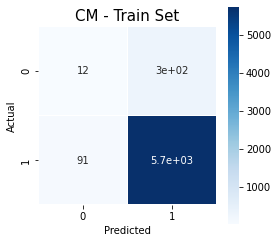

In [ ]:
show_conf_matrix(target, preds2, set1 = "Train", model="")

# Val

In [ ]:
all_preds = []
all_labels = []
model.eval()
with torch.inference_mode():
  for (input, labels) in val_dataloader:
      o = model(input)
      all_preds.append(torch.squeeze(o).cpu().detach().numpy().ravel())
      all_labels.append(torch.squeeze(labels).cpu().detach().numpy().ravel())


all_labels = np.concatenate(all_labels)
all_preds_np = np.concatenate(all_preds)

In [ ]:
import bctools as bc
o = np.squeeze(all_preds_np)
target = all_labels
preds = all_preds_np
auROC_test = bc.curve_ROC_plot(true_y= target, predicted_proba = preds, title = "AUROC - Val" )  
auPRC_test = bc.curve_PR_plot(true_y= target, predicted_proba = preds,  beta = 1, title = "AUPRC - Val" )

In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, precision_recall_curve, confusion_matrix, matthews_corrcoef
preds2 = [1 if i >= 0.5 else 0 for i in preds]
mcc = matthews_corrcoef(target, preds2)
precision = precision_score(target, preds2)
recall = recall_score(target, preds2)
f1 = f1_score(target, preds2, average='weighted')

print("\n")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)
print("\n")
print(classification_report(target, preds2))



Matthews Corr Coef: 0.04416854420453494
Precision: 0.9506995336442372
Recall: 0.9787379972565158
f-1 score: 0.9191308922905072


              precision    recall  f1-score   support

         0.0       0.11      0.05      0.07        78
         1.0       0.95      0.98      0.96      1458

    accuracy                           0.93      1536
   macro avg       0.53      0.52      0.52      1536
weighted avg       0.91      0.93      0.92      1536



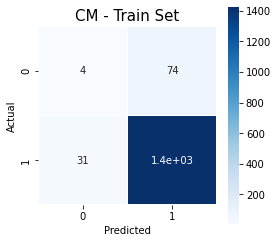

In [ ]:
show_conf_matrix(target, preds2, set1 = "Val", model="")

# Test

In [ ]:

all_preds = []
all_labels = []
model.eval()
with torch.inference_mode():
  for (input, labels) in test_dataloader:
      o = model(input)
      all_preds.append(torch.squeeze(o).cpu().detach().numpy().ravel())
      all_labels.append(torch.squeeze(labels).cpu().detach().numpy().ravel())


all_labels = np.concatenate(all_labels)
all_preds_np = np.concatenate(all_preds)

In [ ]:
import bctools as bc

o = np.squeeze(all_preds_np)
target = all_labels
preds = all_preds_np
auROC_test = bc.curve_ROC_plot(true_y= target, predicted_proba = preds, title = "AUROC - Test" )  
auPRC_test = bc.curve_PR_plot(true_y= target, predicted_proba = preds,  beta = 1, title = "AUPRC - Test" )



In [ ]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, precision_recall_curve, confusion_matrix, matthews_corrcoef
preds2 = [1 if i >= 0.5 else 0 for i in preds]
mcc = matthews_corrcoef(target, preds2)
precision = precision_score(target, preds2)
recall = recall_score(target, preds2)
f1 = f1_score(target, preds2, average='weighted')

print("\n")
print("Matthews Corr Coef:", mcc)
print("Precision:", precision)
print("Recall:", recall)
print("f-1 score:", f1)
print("\n")
print(classification_report(target, preds2))



Matthews Corr Coef: 0.04335389830062675
Precision: 0.9467731204258151
Recall: 0.9800275482093664
f-1 score: 0.9141824211462537


              precision    recall  f1-score   support

         0.0       0.12      0.05      0.07        84
         1.0       0.95      0.98      0.96      1452

    accuracy                           0.93      1536
   macro avg       0.53      0.51      0.52      1536
weighted avg       0.90      0.93      0.91      1536



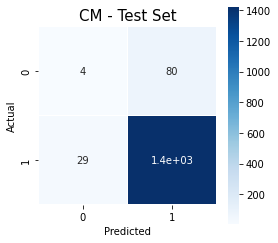

In [ ]:
show_conf_matrix(target, preds2, set1 = "Test", model="")